「文字単位RNNによる名前（苗字）の生成」
===============================================================
【原題】NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

【原著】[Sean Robertson](https://github.com/spro/practical-pytorch)

【元URL】https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年10月24日

【チュトーリアル概要】

名前（苗字）のスペルから、その名前が属する言語を判定するモデルを、文字レベルで処理を実施するRNNを使用して構築します。


---



本チュートリアルでは、単語をクラス分類をする、文字レベルの基本的なRNN（リカレント・ニューラル・ネットワーク）の構築と学習を行います。

本チュートリアルと、これに続く2つのチュートリアルでは、ゼロから自然言語処理モデルを作るためのデータ前処理方法を紹介しています。




特に本チュートリアでは、自然言語処理モデリング用のデータ処理について、基礎から理解できるようになることを目指しています。

したがって、`torchtext`で提供されているような便利なデータ処理の関数はここでは使用しません。




文字レベルのRNNでは、各単語を単なる文字の羅列として扱います。そして各ステップごとに、後に続く文字の予測結果と「隠れ状態」を出力し、前の隠れ状態を次のステップへと送ります。

（日本語訳注：ここでの「ステップ」は1文字単位の処理です。例えば、「ゼロから作成するNLP」なら、ステップ1：「ゼ」→ステップ2：「ロ」→ステップ3：「か」となります）



具体的には、この後、18の言語における数千件の苗字データを使って、苗字のスペルからその苗字がどの言語に属するか判定するモデルを構築します。
（日本語訳注：以下は、実際に苗字が属する言語を予測している例です）
::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


（日本語訳注：上記の結果は、言語の左側にある数値が0に近いほど、その言語の苗字である確率が高いことを示し、マイナス方向に大きくなるほど、その言語の苗字である確率が低いことを示します。）




**本チュートリアルに取り掛かる際の推奨記事:**

本チュートリアルでは、PyTorchとPythonがインストール済みであり、また読者がテンソルについて理解していることを想定しています。


-  https://pytorch.org/ PyTorchのインストールガイドです
-  [DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) は、PyTorchを始める方向けの記事です（日本語訳では、「PyTorch入門」で提供）
-  [LEARNING PYTORCH WITH EXAMPLES](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) は、PyTorchをより広く・深く理解する方向けの記事です（日本語訳では、「PyTorch入門」で提供）
-  [PyTorch for Former Torch Users](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) は、PyTorchの前身であるLua Torchユーザー向けの記事です






RNNの概要と仕組みを理解するにあたっては、以下の記事がおすすめです。

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
   には実例が豊富です。
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   はLSTMに関する記事ですが、RNNの一般的な理解にとっても有益です。

<br>

（日本語訳注：RNNを理解するにあたって、個人的に役立った日本語の記事を以下に記載します

- [再帰型ニューラルネットワークの「基礎の基礎」を理解する](https://www.imagazine.co.jp/%E5%86%8D%E5%B8%B0%E5%9E%8B%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%80%8C%E5%9F%BA%E7%A4%8E%E3%81%AE%E5%9F%BA%E7%A4%8E%E3%80%8D/)
- [リカレントニューラルネットワーク（RNN）の基礎](https://qiita.com/_oshiritantei/items/3494590a92c609cf0e50)





データの準備
==================

---

【注釈】

データを[ここ](https://download.pytorch.org/tutorial/data.zip)からダウンロードし、カレント・ディレクトリに展開してください

（日本語訳注：日本語版の本チュートリアルでは自動的にファイルをダウンロードして使用可能にするセルを冒頭に追加しています）

---

<br>

`data/names` ディレクトリには、18個のテキストファイルが、”[言語名].text”という名称で格納されています。

各ファイルには苗字のリストが格納されおり、一行が一つの苗字となっています。

また、ほとんどの苗字はローマ字になっています（ただし、文字コードをUnicodeから ASCIIに変換する必要があります）


In [2]:
%matplotlib inline

In [70]:
# 日本語訳注：サンプルデータをダウンロードし、zipファイルを解凍するセルを追加
import os
import subprocess
import zipfile
if os.path.exists('./data/names'):
  print("./dat/ already exists")
else:
  subprocess.run("wget https://download.pytorch.org/tutorial/data.zip",shell=True, check=True)
  with zipfile.ZipFile("./data.zip") as zipfile:
    zipfile.extractall(".")

--2024-07-01 16:36:11--  https://download.pytorch.org/tutorial/data.zip
download.pytorch.org (download.pytorch.org) をDNSに問いあわせています... 13.249.146.45, 13.249.146.106, 13.249.146.93, ...
download.pytorch.org (download.pytorch.org)|13.249.146.45|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 2882130 (2.7M) [application/zip]
`data.zip.2' に保存中

     0K .......... .......... .......... .......... ..........  1% 10.2M 0s
    50K .......... .......... .......... .......... ..........  3% 21.0M 0s
   100K .......... .......... .......... .......... ..........  5% 16.8M 0s
   150K .......... .......... .......... .......... ..........  7% 24.5M 0s
   200K .......... .......... .......... .......... ..........  8% 29.9M 0s
   250K .......... .......... .......... .......... .......... 10% 33.4M 0s
   300K .......... .......... .......... .......... .......... 12% 38.6M 0s
   350K .......... .......... .......... .......... .......... 14% 37.0M 0s
   400K .......... ..........

In [71]:
# 日本語訳注：サンプルデータをダウンロードし、zipファイルを解凍するセルを追加
!ls

README.md  data.zip.1		    pyproject.toml	   src
data	   data.zip.2		    requirements-dev.lock
data.zip   myanimelist-dataset.zip  requirements.lock


In [72]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


これで、各カテゴリ (言語) を行 (苗字） のリストにマッピングした、辞書型変数 `category_line`を作成できました。

また、上記コードでは、後で参照できるように、`all_categories` (言語のリスト) と `n_categories`（言語の数）という変数も用意しています。




In [73]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


苗字データのテンソルへの変換
--------------------------

これですべての苗字を辞書型変数として整理することができました。

次にこの苗字データをPyTorch上で扱うために、データの形式をテンソルに変換します。





一つの文字は、`<1 x n_letters>`サイズの、 "ワンホットベクトル "を使って表現されます。

ワンホットベクトルは、表現したい文字のインデックス（=位置）にのみ1が格納され、それ以外のインデックス（＝位置）は0で埋められたベクトルです。

例えば、"b"という文字であれば、`"b" =<0 1 0 0 0 ...>`という形で表現します。

（日本語訳注 ："b"は、ローマ字では二番目の文字であるため、二番目のみ1でそれ以外は0のベクトルで表現されます。"c"なら、ローマ字の3番目なので、`"c" =<0 0 1 0 0 ...>`という形式で表現されます。）





単語を作るためには、これらを2次元の行列 `<line_length x 1 x n_letters>` に結合します。

（日本語訳注 ：例えば、"abc"という単語であれば、
`"abc" =<1 0 0 0 0 ...>, <0 1 0 0 0 ...>, <0 0 1 0 0 ...>`のように表現されるイメージです。）

<br>

`line_length`と`n_letters`の間にある余分に見える1次元は、バッチサイズです。

この次元は、PyTorchではデータをすべてバッチとして処理する仕様のため、必要となります。

ここでは、バッチサイズは1としています。

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):# -> Any:
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


ネットワークの構築
====================

autograd（自動勾配計算モジュール）ができる前は、Torchでリカレント・ニューラルネットワークを作成する際には、学習ステップごとにネットワーク内のレイヤーのパラメータの情報を取得する必要がありました。

以前はレイヤー側が隠れ状態や勾配の情報を保持しており、レイヤーごとにパラメータ更新の記述が必要だったためです。



しかし現在では、テンソルの計算グラフ自体が、隠れ状態や勾配の情報を全て保持しています。

これは、RNNを非常に「シンプルな」方法で（=通常の順伝播モジュールとして）実装できることを意味します。

このRNNモジュールは、inputデータと隠れ状態（hidden）に対し適用される2つの線形レイヤーと、出力の後にLogSoftmaxレイヤーがあるだけのものです（以下のコードはほとんどが、[the PyTorch for Torch users チュートリアル](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net)からコピー）。

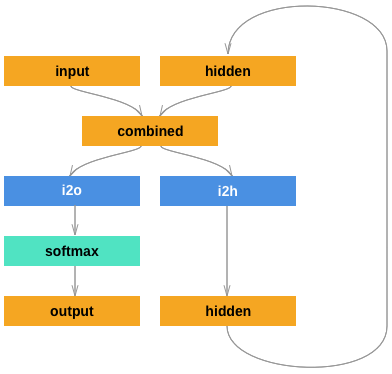

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

このネットワークのステップを実行するには、入力データ（ここでは、現在の文字のテンソル）と、一つ前の文字の隠れ状態（最初はゼロで初期化）を渡す必要があります。

実際に実行すると、出力（各言語の確率）と、次のステップでの予測の際に与えるRNNの隠れ状態を取得することができます。

In [9]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

計算効率上、学習ステップごとに新しいテンソルを作成することは避けたいです。

そこで`letterToTensor`の代わりに、`lineToTensor`を使用し、まず一度単語のテンソルを作成します。

そしてスライスを使い、単語のテンソルから各文字のテンソルを取得します。

さらに効率的にするために、単語ではなく、バッチのテンソルを事前に計算しておく方法もあります。

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9754, -2.9102, -2.9096, -2.8115, -2.9530, -2.9250, -2.8035, -2.8423,
         -2.9204, -2.8731, -2.8506, -2.7651, -2.9330, -2.9137, -2.9607, -2.8677,
         -2.9073, -2.9337]], grad_fn=<LogSoftmaxBackward0>)


ご覧のように、出力は`<1 x n_categories>`のテンソルとなり、各項目はそのカテゴリ（苗字の言語）に対する尤度です（0に近いほどそのカテゴリに属する可能性が高くなります）。

訓練
========
訓練の準備
----------------------

訓練に入る前に、いくつかの補助関数（ヘルパー関数）を作る必要があります。

一つ目は、ネットワークの出力を解釈するための関数です。

テンソルにおける最大値のインデックスを得るために`Tensor.topk`を使うことができます。





In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 11)


また、訓練用にデータの具体例（苗字とその言語）を簡単に取得して、提示する関数もあると便利です。

In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    print(category_tensor)
    print(line_tensor)

category = Italian / line = Bagnoli
tensor([17])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

ネットワークの訓練
----------------------

このネットワークの訓練に必要なプロセスは、多くの正解付きデータ（アノテーション付きの教師データ）を入力して推論させ、推論結果の良否をフィードバックすることです。

RNNの最後の層は`nn.LogSoftmax`なので、対応する損失関数は`nn.NLLLoss`となります。

In [ ]:
criterion = nn.NLLLoss()

訓練のループは以下に示す順番で進みます。

- 入力テンソルと正解テンソルを作成
- 初期の隠れ状態（値はゼロ）の作成
- それぞれの文字を読み込み、
  - 次の文字のために隠れ状態を保持
- 最終出力を正解と比較
- 誤差逆伝播
- 出力と損失を返す

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

あとは、大量のサンプルデータを使用して訓練ループを実行するだけです。

`train`関数は出力と損失の両方を返すので、推論結果を表示したり、プロットするために損失を求めることができます。

数千のデータがあるので、`print_every`で、指定したイテレーションごとに損失の平均を求め、print文で出力します。

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.4936 Freitas / Greek ✗ (Portuguese)
10000 10% (0m 13s) 1.0116 Sin / Korean ✓
15000 15% (0m 21s) 1.2960 Stevenson / Scottish ✓
20000 20% (0m 27s) 2.5995 Campbell / Dutch ✗ (Scottish)
25000 25% (0m 34s) 0.4008 Kawaguchi / Japanese ✓
30000 30% (0m 40s) 1.4910 Mcintosh / Scottish ✓
35000 35% (0m 48s) 2.8484 Santos / Greek ✗ (Spanish)
40000 40% (0m 54s) 0.8155 Ta / Vietnamese ✓
45000 45% (1m 2s) 0.3763 Yoo / Korean ✓
50000 50% (1m 9s) 1.5818 Zogby / Arabic ✓
55000 55% (1m 16s) 0.8649 Durkin / Russian ✓
60000 60% (1m 23s) 0.9285 Lukhovitsky / Russian ✓
65000 65% (1m 29s) 0.0495 Malihoudis / Greek ✓
70000 70% (1m 36s) 0.2325 Slaski / Polish ✓
75000 75% (1m 43s) 0.5220 Kourempes / Greek ✓
80000 80% (1m 50s) 1.6621 Edmunds / English ✓
85000 85% (1m 57s) 1.6636 Geryk / Polish ✗ (Czech)
90000 90% (2m 4s) 1.1245 Che / Korean ✗ (Chinese)
95000 95% (2m 10s) 2.1723 Cousineau / Irish ✗ (French)
100000 100% (2m 19s) 0.6534 Vincent / French ✓


結果のプロット
--------------------

`all_losses`から過去の損失をプロットすると、ネットワーク学習の様子がわかります

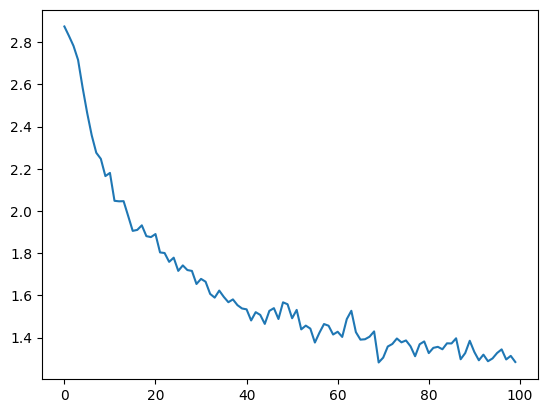

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

結果の評価
======================

ネットワークが各カテゴリ（言語）に対して、どの程度の性能を発揮しているのかを確認するために、実際の言語（=行）ごとに、ネットワークの推論結果がどの言語だったのか（列）を示す、混同行列（confusion matrix）を作成します。

混同行列を計算するために、`evaluate()`関数を用いて多くのサンプルを入力としてネットワークを実行しますが、この`evaluate()`関数は、逆伝播を実行しない`train()`関数と同義です。


<ipython-input-17-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-17-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


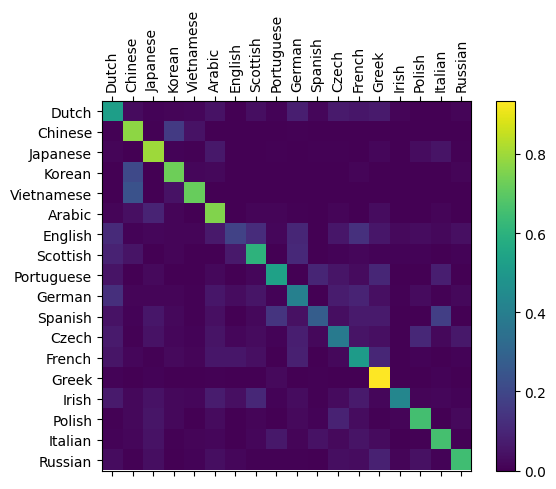

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

斜めの軸の点の明るさから、どの言語で推測結果に間違いが多いか分かります

（日本語訳注：点が暗いほどその言語に対する予測結果は間違いが多く、明るいほど正解が多いことを示しています）。

例えば、ギリシャ語では非常に良く、英語では非常に悪いようです（これはおそらく、英語の苗字は他の言語との重複が多いためでしょう）。

ユーザーが入力した苗字に対する推論実行
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.78) Russian
(-1.01) Czech
(-2.66) Polish

> Jackson
(-0.97) Scottish
(-1.46) English
(-1.87) French

> Satoshi
(-1.31) Japanese
(-1.44) Italian
(-1.58) Arabic


In [ ]:
# 日本語訳追記：[1] 上記の結果は実行の度に変わります。[2] 今回は検証のデータセットを用意していないので、過学習する恐れがあります。

# 田中で試す
predict('Saito')



> Saito
(-0.90) Portuguese
(-1.40) Japanese
(-1.78) Italian


[in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)にあるスクリプトの最終バージョンでは、上記のコードをいくつかのファイルに分割しています。

- `data.py` (データファイルのロード)
- `model.py` (RNNの定義)
- `train.py` (トレーニングの実行)
- `predict.py` (コマンドライン引数で `predict()` の実行)
- `server.py` (bottle.pyを用いたJSON APIとしての推論結果提供)

ネットワークを訓練して保存するには `train.py` を実行してください。

予測結果を表示するには、名前を付けて `predict.py` を実行してください。

```:cmd
    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech
```

`server.py`を実行し、 http://localhost:5533/Yournameto にアクセスして予測結果のJSONを取得してください。



演習
=========

- 本チュートリアルで使ったデータとは異なる、行 -> カテゴリ を判定するデータセットで試してみてください。例えば、以下などです。

   - 任意の単語 -> 言語
   - 下の名前 -> 性別
   - キャラクター名 -> 著者
   - ページタイトル -> ブログまたはウェブページ

- ネットワークを大きくしたり、またはネットワークの構造を改善したりして、さらに良い結果を目指してください。例えば、以下のような改善が考えられます。

   - より多くの線形レイヤーを追加
   - `nn.LSTM` と `nn.GRU` のレイヤーを試す
   - 上記のような複数の`RNN`を、組み合わせた高次元のネットワークを試す

